In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

C:\Users\alini\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\alini\AppData\Local\Programs\Python\Python38\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 1. Load the provided datasets

In [2]:
data_dir = 'static/lcdp_dataset'
input_dir = os.path.join(data_dir, 'input')
gt_dir = os.path.join(data_dir, 'gt')
valid_input_dir = os.path.join(data_dir, 'valid-input')
valid_gt_dir = os.path.join(data_dir, 'valid-gt')
test_input_dir = os.path.join(data_dir, 'test-input')
test_gt_dir = os.path.join(data_dir, 'test-gt')

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 because original images are very large
    transforms.ToTensor()
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_root, gt_root, transform=None):
        self.input_root = input_root
        self.gt_root = gt_root
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for filename in os.listdir(self.input_root):
            if os.path.isfile(os.path.join(self.input_root, filename)):
                sample = (filename,)
                samples.append(sample)
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        filename = self.samples[index][0]
        input_image = Image.open(os.path.join(self.input_root, filename))
        gt_image = Image.open(os.path.join(self.gt_root, filename))
        if self.transform is not None:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)
        return input_image, gt_image

# Load the train dataset
train_dataset = CustomDataset(input_dir, gt_dir, transform=data_transform)

# Load the validation dataset
valid_dataset = CustomDataset(valid_input_dir, valid_gt_dir, transform=data_transform)

# Load the test dataset
test_dataset = CustomDataset(test_input_dir, test_gt_dir, transform=data_transform)

# Create data loaders for train, validation, and test datasets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# Example on how to use data loader:
for input_train, gt_train in train_loader:
    print(input_train.shape)
    print(gt_train.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])


# Part 2. Build the Model Structure

In [4]:
# Define LCDE module

class LCDEModule(nn.Module):
    def __init__(self):
        super(LCDEModule, self).__init__()

        # Define your LCDE module architecture here

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 1, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_image):
        x = self.conv1(input_image)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        guided_mask = self.conv3(x)
        guided_mask = self.sigmoid(guided_mask)

        return guided_mask


# Define dual-illumination estimation module
class DualIllumEstimation(nn.Module):
    def __init__(self):
        super(DualIllumEstimation, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 3, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_image):
        x = self.conv1(input_image)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        dual_illumination = self.conv3(x)
        dual_illumination = self.sigmoid(dual_illumination)

        return dual_illumination


class FusionNetwork(nn.Module):
    def __init__(self):
        super(FusionNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x, illumination_1, illumination_2):
        x = self.conv1(x)
        x = self.relu(x)
        x = x * (illumination_1 + illumination_2)  # Element-wise multiplication with the illuminations
        x = self.conv2(x)
        enhanced_image = torch.sigmoid(x)

        return enhanced_image


In [5]:
# Model which uses above modules and networks
import torch.nn.functional as F

class LCDEModel(nn.Module):
    def __init__(self):
        super(LCDEModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.lcde_module = LCDEModule()  # Similar to the lcde module that mentioned in paper
        self.dual_illum_estimation = DualIllumEstimation()  # Similar to the dual illumination estimation network in paper
        self.fusion_network = FusionNetwork()  # Similar to the mentioned fusion network in paper


    def forward(self, input_image):
        guided_mask = self.lcde_module(input_image)

        illuminations = self.dual_illum_estimation(input_image)
        illumination_1 = illuminations[0]
        illumination_2 = illuminations[1]

        # Incorporate the guided mask and illuminations into the network architecture
        x = self.encoder(input_image)
        guided_mask_resized = F.interpolate(guided_mask, size=x.size()[2:], mode='bilinear', align_corners=False)
        x = x * guided_mask_resized  # Element-wise multiplication with the resized guided mask
        x = self.decoder(x)
        enhanced_image = x * (illumination_1 + illumination_2)  # Element-wise multiplication with the illuminations

        return enhanced_image


# Part 3. Train the model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
torch.cuda.is_available()

False

In [9]:
model = LCDEModel().to(device)

In [10]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
criterion = nn.MSELoss() ## Using MSE loss function, its also mentioned in the paper

In [12]:
num_epochs = 50

In [13]:
load_our_alrdy_trained_model = False
if load_our_alrdy_trained_model:
    model = model.load_state_dict(torch.load("trained_model.pth"))

In [15]:
from tqdm import tqdm

train_losses = []
val_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images in tqdm(train_loader):
        input_images = images[0].to(device)
        gt_images = images[1].to(device)

        optimizer.zero_grad()
        enhanced_images = model(input_images)
        loss = criterion(enhanced_images, gt_images)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Compute validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images in tqdm(valid_loader):
            input_images = images[0].to(device)
            gt_images = images[1].to(device)

            enhanced_images = model(input_images)
            loss = criterion(enhanced_images, gt_images)
            val_loss += loss.item()

    val_loss /= len(valid_loader)
    val_losses.append(val_loss)

    test_loss = 0.0
    with torch.no_grad():
        for images in tqdm(test_loader):
            input_images = images[0].to(device)
            gt_images = images[1].to(device)

            enhanced_images = model(input_images)
            loss = criterion(enhanced_images, gt_images)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Save losses to file
    with open("losses.txt", "w+") as file:
        file.write(f"Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}\n")

    # Print losses to console
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

print("Training finished")


  0%|          | 0/23 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [16]:
# save my alrdy trained model
save_path = "trained_model_2.pth"
torch.save(model.state_dict(), save_path)

# Part 4. Analyse trained model

## Part 4.1 Loss Curves of Training, Validation and Test Sets

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

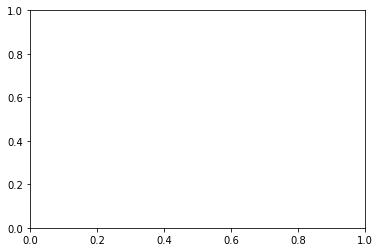

In [17]:
import matplotlib.pyplot as plt

# Plot losses
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Losses')
plt.legend()
plt.show()


# Part 4.2 Test Trained Model on a Test Image, Check result visually

In [18]:
import matplotlib.pyplot as plt
import random
pick_one = 0 # 0-63

# Load the model
model_state_dict = torch.load('trained_model.pth')
model = LCDEModel()
model.load_state_dict(model_state_dict)

# Get the first item from the test loader (input image)
input_image, ground_truth_image = next(iter(test_loader))

# Set the model to evaluation mode
model.eval()

# Pass the input image through the model
with torch.no_grad():
    enhanced_image = model(input_image)

# Convert the output tensor to a numpy array
enhanced_image = enhanced_image.permute(0, 2, 3, 1).numpy()

# Visualize or save the enhanced image
print(enhanced_image.shape)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,9))

ax1.imshow(input_image[pick_one].permute(1,2,0).numpy())
ax2.imshow(enhanced_image[pick_one])
ax3.imshow(ground_truth_image[pick_one].permute(1, 2, 0).numpy())

ax1.set_title("Input image")
ax2.set_title("Predicted image")
ax3.set_title("Ground truth image")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'trained_model.pth'